# Practica Deep Learning


Importamos todas las librerias que vamos a necesitar para realizar todo el modelo incluyendo el archivo module_utils

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2
from sklearn.preprocessing import MultiLabelBinarizer
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from module_utils import plot_training_curves
import optuna

d:\anaconda3\envs\torchgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuración del device y de la semilla

In [46]:
SEED = 10
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

def seed_worker():
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")

Usando dispositivo: cuda


Leemos el dataset

In [3]:
df = pd.read_csv("poi_dataset.csv")

Y exploramos los datos

In [4]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568
id,4b36a3ed-3b28-4bc7-b975-1d48b586db03,e32b3603-a94f-49df-8b31-92445a86377c,0123a69b-13ac-4b65-a5d5-71a95560cff5,390d7d9e-e972-451c-b5e4-f494af15e788,023fc1bf-a1cd-4b9f-af78-48792ab1a294,bcd58127-76bd-44e7-84d8-cc25b46c7962,f45b1b38-36cd-4479-bac1-544ca6b1e685,ca8d89fa-3e9e-4639-ac01-7f83c5d0130e,0089bb20-c132-496c-b215-1986fcfa9d4b,297257de-a00a-4e99-bd21-b3a2c529e916,...,c5c29bd8-c3bc-4405-82ed-7d17d89238ae,4f0f97a5-aa50-4f27-b26c-72909626fb7a,2f3f2208-0682-4ebb-98be-79155ea07783,2d399e39-055a-4469-b2ef-06cfa4345560,6722f309-c1e8-446a-bcec-ff4d8b448923,a1058fc5-8b4e-43db-8758-2a4197eb69ca,77df8476-484e-436e-8977-f957f6b9371a,21c741f5-cbe7-4ae0-a69d-b5c1622056af,4b8b38fa-78b5-4ea8-a676-1de4e2b48caa,d7f45b8d-c311-4309-a85a-d91f1fcd3b2f
name,Galería Fran Reus,Convento de San Plácido,Instituto Geológico y Minero de España,Margarita Gil Roësset,Museo del Traje. Centro de Investigación del P...,Clara Campoamor,Plaza de la Encarnación,Atentado en 1985,Cuesta de los ciegos,Fragmento de la muralla árabe de Madrid,...,Sin datos,Portada,Asilo de nombres usados,"Curiosidades, datos y pormenores de la villa d...",El viaducto,"Plaza de Puerta Cerrada, en Madrid",¡Aquel Madrid!,El viento se acuesta al atardecer,Edificio Metrópolis por Herreros,Monasterio de Moreruela
shortDescription,La Galería Fran Reus es un espacio dedicado a ...,"El Convento de San Plácido en Madrid, fundado ...","El Instituto Geológico y Minero de España, sit...","Margarita Gil Roësset, escultora y poetisa esp...","El Museo del Traje de Madrid, fundado en 2004,...","Clara Campoamor fue una abogada, escritora y p...",Debe su nombre al desaparecido convento de la ...,1985. ETA asesina en Madrid al coronel auditor...,La Cuesta de los Ciegos es una escalera empedr...,Este vestigio de la muralla árabe del siglo IX...,...,"BARAHONA (José Barahona Marco)\nSin datos, ca....","JOSÉ MARÍA PICÓ LÓPEZ\nPortada\nABC, núm. 13.9...",JUAN ESPLANDIÚ PEÑA\nAsilo de nombres usados\n...,"JUAN ESPLANDIÚ PEÑA\nCuriosidades, datos y por...",JOSÉ FRANCISCO AGUIRRE PÉREZ\nEl viaducto\nBla...,"ANTONIO ORBEGOZO\nPlaza de Puerta Cerrada, en ...","JUAN ESPLANDIÚ PEÑA\n¡Aquel Madrid!\nABC, núm....",SERNY (Ricardo Summers e Isern)\nEl viento se ...,HERREROS (Enrique García-Herreros Codesido)\nS...,"Descubre el Monasterio de Moreruela, una joya ..."
categories,"['Escultura', 'Pintura']","['Patrimonio', 'Historia']","['Ciencia', 'Patrimonio']",['Cultura'],"['Patrimonio', 'Cultura']","['Historia', 'Cultura']","['Historia', 'Arquitectura']",['Historia'],"['Arquitectura', 'Historia']","['Arquitectura', 'Patrimonio']",...,['Pintura'],['Pintura'],['Pintura'],['Pintura'],['Pintura'],['Pintura'],['Pintura'],['Pintura'],['Pintura'],"['Patrimonio', 'Historia', 'Arquitectura']"
tier,1,1,2,1,1,1,2,3,3,2,...,1,1,1,1,1,1,1,1,1,1
locationLon,2.642262,-3.704467,-3.699694,-3.691228,-3.727822,-3.690211,-5.992007,-3.677161,-3.714567,-3.714546,...,-3.688483,-3.703395,-3.690199,-3.704049,-3.715019,-3.707943,-3.68912,-3.712121,-3.695836,-5.7776
locationLat,39.572694,40.423037,40.442045,40.427256,40.439665,40.435082,37.392953,40.4358,40.412984,40.414866,...,40.420718,40.417073,40.409594,40.417024,40.413979,40.413677,40.416555,40.419088,40.418698,41.812321
tags,[],[],[],[],[],[],[],[],[],[],...,"['Constructivismo', 'cartel']","['Nochevieja', 'ABC', 'Periodismo', 'portada']","['César González-Ruano', 'Juan Esplandiú Peña'...",['Puerta del sol'],"['Viaducto', 'Puente']",['Cruz'],"['Puerta', 'Parque del Retiro']","['Estatuas', 'Plaza']","['Alcalá', 'Gran Vía', 'Metrópolis']","['Arquitectura', 'Cisterciense', 'Císter', 'Mo..."
xps,500,500,250,500,500,500,250,100,150,250,...,600,600,600,600,600,600,600,600,600,500
Visits,10009,10010,10015,10011,10020,10019,10013,10019,10007,10018,...,10009,10010,10009,10012,10005,10014,10013,10005,10006,10011


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1569 non-null   object 
 1   name              1569 non-null   object 
 2   shortDescription  1569 non-null   object 
 3   categories        1569 non-null   object 
 4   tier              1569 non-null   int64  
 5   locationLon       1569 non-null   float64
 6   locationLat       1569 non-null   float64
 7   tags              1569 non-null   object 
 8   xps               1569 non-null   int64  
 9   Visits            1569 non-null   int64  
 10  Likes             1569 non-null   int64  
 11  Dislikes          1569 non-null   int64  
 12  Bookmarks         1569 non-null   int64  
 13  main_image_path   1569 non-null   object 
dtypes: float64(2), int64(6), object(6)
memory usage: 171.7+ KB


cambiamos las columnas "categories" y "tags" de strings a listas

In [6]:
df["categories"] = df["categories"].apply(eval)
df["tags"] = df["tags"].apply(eval)

Hacemos un one hot de la columna categories

In [7]:
mlb = MultiLabelBinarizer()
one_hot_categories = mlb.fit_transform(df["categories"])

Concatenamos el onehot al dataset y eliminamos la columna categories

In [8]:
df = pd.concat([df, pd.DataFrame(one_hot_categories, columns=mlb.classes_)], axis=1)
df.drop(columns=["categories"], inplace= True)

Añadimos la columna n_tags, que aplica el numero de tags que tiene, por lo que eliminamos la columna tags

In [9]:
df["n_tags"] = df["tags"].apply(len)
df.drop(columns=["tags"], inplace= True)

Eliminamos las columnas id, name, shortDescription, porque no aportan valor al modelo ya que no vamos a analizar texto

In [10]:
df.drop(columns=["id", "name", "shortDescription"], inplace= True)

In [11]:
df.head().T

,0,1,2,3,4
tier,1,1,2,1,1
locationLon,2.642262,-3.704467,-3.699694,-3.691228,-3.727822
locationLat,39.572694,40.423037,40.442045,40.427256,40.439665
xps,500,500,250,500,500
Visits,10009,10010,10015,10011,10020
Likes,422,7743,3154,8559,915
Dislikes,3582,96,874,79,2896
Bookmarks,78,2786,595,2358,143
main_image_path,data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03...,data_main/e32b3603-a94f-49df-8b31-92445a86377c...,data_main/0123a69b-13ac-4b65-a5d5-71a95560cff5...,data_main/390d7d9e-e972-451c-b5e4-f494af15e788...,data_main/023fc1bf-a1cd-4b9f-af78-48792ab1a294...
Arquitectura,0,0,0,0,0


Definimos el target

In [12]:
df[['Visits', 'Likes', 'Dislikes', 'Bookmarks']].describe()

,Visits,Likes,Dislikes,Bookmarks
count,1569.000000,1569.000000,1569.000000,1569.000000
mean,10011.943276,3623.908222,2526.305927,973.261950
std,5.456808,4817.879374,2225.543360,1453.333948
min,10001.000000,100.000000,52.000000,50.000000
25%,10008.000000,464.000000,937.000000,116.000000
50%,10011.000000,1434.000000,2718.000000,306.000000
75%,10015.000000,6840.000000,3399.000000,1309.000000
max,10038.000000,26425.000000,10999.000000,8157.000000


No hay varianza en visitas por lo que la descarto para la variable objetivo:

In [19]:
df["target"] = np.log1p(df['Likes'] + df['Bookmarks'] * 2) - np.log1p(df['Dislikes'])

Text(0.5, 1.0, 'Distribución target')

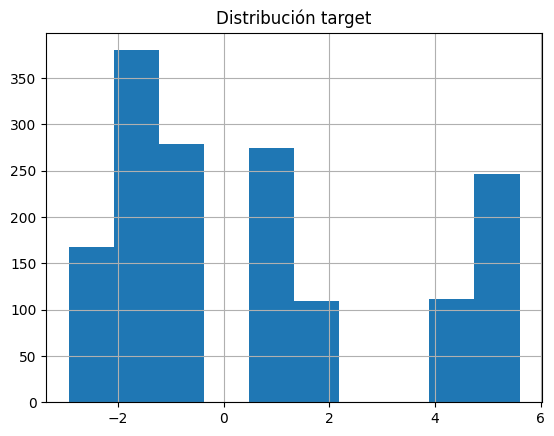

In [26]:
df['target'].hist(bins=10); plt.title("Distribución target")

Y definimos la columna engagement_class que clasifica los datos según el target. Si está por debajo del 33% de los datos lo tratamos como 0, si está entre 33% y el 66% lo tratamos como 1 y por encima del 66% como 2.

In [21]:
low_threshold = df['target'].quantile(0.33)
high_threshold = df['target'].quantile(0.66)

def classify_engagement(score):
    if score < low_threshold:
        return 0
    elif score < high_threshold:
        return 1
    else:
        return 2

df['engagement_class'] = df['target'].apply(classify_engagement)

In [22]:
df['engagement_class'].value_counts()

engagement_class
2    534
0    518
1    517
Name: count, dtype: int64

In [27]:
df.head().T

,0,1,2,3,4
tier,1,1,2,1,1
locationLon,2.642262,-3.704467,-3.699694,-3.691228,-3.727822
locationLat,39.572694,40.423037,40.442045,40.427256,40.439665
xps,500,500,250,500,500
Visits,10009,10010,10015,10011,10020
Likes,422,7743,3154,8559,915
Dislikes,3582,96,874,79,2896
Bookmarks,78,2786,595,2358,143
main_image_path,data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03...,data_main/e32b3603-a94f-49df-8b31-92445a86377c...,data_main/0123a69b-13ac-4b65-a5d5-71a95560cff5...,data_main/390d7d9e-e972-451c-b5e4-f494af15e788...,data_main/023fc1bf-a1cd-4b9f-af78-48792ab1a294...
Arquitectura,0,0,0,0,0


In [28]:
df['tier'].value_counts()

tier
1    837
2    622
3    103
4      7
Name: count, dtype: int64

In [32]:
df['n_tags'].value_counts()

n_tags
10    473
13    466
1     136
0     107
4     102
12     88
5      58
3      56
6      33
2      24
7      10
8       8
11      6
9       2
Name: count, dtype: int64

Analizamos las dimensiones de las imagenes:

In [31]:
df["main_image_path"].apply(lambda x:cv2.imread(x).shape).value_counts()

main_image_path
(128, 128, 3)    1569
Name: count, dtype: int64

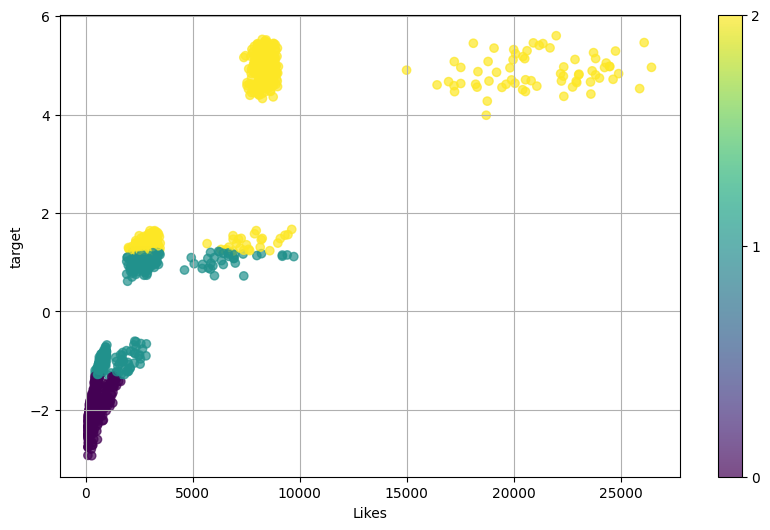

In [33]:
x_feature = 'Likes'
y_feature = 'target'

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df[x_feature], df[y_feature], c=df['engagement_class'], cmap='viridis', alpha=0.7)
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.colorbar(scatter, ticks=[0, 1, 2])
plt.grid(True)
plt.show()

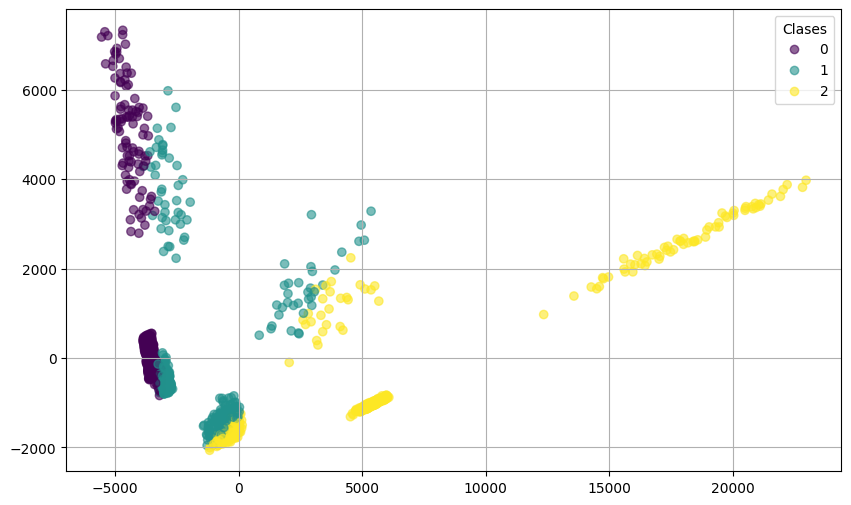

In [34]:
exclude_cols = ['main_image_path', 'engagement_class']
feature_cols = [col for col in df.columns if col not in exclude_cols]

pca = PCA(n_components=2)
features_2d = pca.fit_transform(df[feature_cols])

plt.figure(figsize=(10, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=df["engagement_class"], cmap='viridis', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Clases")
plt.grid(True)
plt.show()

Dividimos los datos en train(80%), test(20%) y validación(20% de los datos de train)

In [35]:
train_val_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['engagement_class'],
    random_state=SEED
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    stratify=train_val_df['engagement_class'],
    random_state=SEED
)

print(f'Tamaño train: {len(train_df)}')
print(f'Tamaño val: {len(val_df)}')
print(f'Tamaño test: {len(test_df)}')

Tamaño train: 1004
Tamaño val: 251
Tamaño test: 314


Creamos el Dataset POI (Point Of Interest):

In [36]:
class POI(Dataset):
    
    def __init__(self, target, image_path, features, transform =None):
        self.target = torch.tensor(target)
        self.image_path = image_path
        self.features = torch.tensor(features)
        self.transform = transform
    
    def __len__(self):
        return len(self.target)

    
    def __getitem__(self, index):

        target = self.target[index]
        features = self.features[index]
        
        image = cv2.imread(self.image_path[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 


        if self.transform is not None:
            image = self.transform(image)

        return target, features, image

Definimos la secuencia de pasos de preprocesamiento que se aplicarán uniformemente a cada imagen:

In [37]:
image_transforms_cv2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128), antialias=True), #Añado esta linea como seguridad, ya que, a pesar de que todas las imagenes son 128x128, no sabemos si nuevas imagenes van a tener esas dimensiones
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [38]:
image_transforms_cv2_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128), antialias=True), #Añado esta linea como seguridad, ya que, a pesar de que todas las imagenes son 128x128, no sabemos si nuevas imagenes van a tener esas dimensiones
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

Preparamos y dividimos los datos en caractarísticas para train, validación y test:

In [39]:
exclude_cols = ['main_image_path', 'engagement_class', 'target', 'Likes', 'Dislikes', 'Visits', 'Bookmarks']
feature_cols = [col for col in df.columns if col not in exclude_cols]

# TRAIN
train_targets = train_df['engagement_class'].values
train_paths = train_df['main_image_path'].values
train_features = train_df[feature_cols].to_numpy()

# VAL
val_targets = val_df['engagement_class'].values
val_paths = val_df['main_image_path'].values
val_features = val_df[feature_cols].to_numpy()

# TEST
test_targets = test_df['engagement_class'].values
test_paths = test_df['main_image_path'].values
test_features = test_df[feature_cols].to_numpy()

test_dataset = POI(test_targets, test_paths, test_features, transform=image_transforms_cv2)

Creamos el modelo con capas convolucionales, lineales y el clasificador:

In [40]:
class Model(nn.Module):
    def __init__(self, num_metadata_features, hidden_size, dropout_rate, num_classes=3):
        super(Model, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2),

        )
        
        self.cnn_output_dim = 64 * 16 * 16
        
        self.metadata = nn.Sequential(
            nn.Linear(num_metadata_features, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.cnn_output_dim + 64, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, metadata, image_data):
        img_out = self.cnn(image_data)
        img_out = img_out.view(img_out.size(0), -1)

        meta_out = self.metadata(metadata)

        combined = torch.cat((img_out, meta_out), dim=1)
        output = self.classifier(combined)
        return output

Creamos la función que entrena y evalua el modelo:

In [41]:
def train_model(model, learning_rate, epochs, batch_size, trial=None):

    train_dataset = POI(train_targets, train_paths, train_features, transform=image_transforms_cv2_train)
    val_dataset = POI(val_targets, val_paths, val_features, transform=image_transforms_cv2)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1)

    best_val_accuracy = 0.0


    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):

        model.train()
        total_train_loss, total_train_preds, total_train_labels = 0, [], []

        for labels, metadata, images in train_loader:
            labels = labels.to(DEVICE).long()
            metadata = metadata.to(DEVICE).float()
            images = images.to(DEVICE).float()

            optimizer.zero_grad()
            outputs = model(metadata, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            total_train_preds.extend(preds.cpu().numpy())
            total_train_labels.extend(labels.cpu().numpy())

        train_loss = total_train_loss / len(train_loader)
        train_acc = accuracy_score(total_train_labels, total_train_preds)

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        total_val_loss, total_val_preds, total_val_labels = 0, [], []

        with torch.no_grad():
            for labels, metadata, images in val_loader:
                labels = labels.to(DEVICE).long()
                metadata = metadata.to(DEVICE).float()
                images = images.to(DEVICE).float()

                outputs = model(metadata, images)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                total_val_preds.extend(preds.cpu().numpy())
                total_val_labels.extend(labels.cpu().numpy())

        val_loss = total_val_loss / len(val_loader)
        val_acc = accuracy_score(total_val_labels, total_val_preds)

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc

        if trial is not None:
            trial.report(val_acc, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
            
    plot_training_curves(train_losses, val_losses, train_accs, val_accs, epochs)

    return best_val_accuracy

Definimos la funcion objetive para la busqueda de hiperparámetros:

In [42]:
def objective(trial):

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    hidden_size = trial.suggest_categorical('hidden_size', [128, 256, 512])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    epochs = trial.suggest_int('epochs', 10, 50)

    num_metadata_features = train_features.shape[1]
    
    model = Model(num_metadata_features=num_metadata_features, 
                  hidden_size=hidden_size, 
                  dropout_rate=dropout_rate).to(DEVICE)
    
    val_accuracy = train_model(model, learning_rate, epochs, batch_size, trial) 
    
    return val_accuracy

Buscamos los mejores hiperparámetros con optuna para entrenar el modelo:

[I 2025-06-15 09:58:22,891] Using an existing study with name 'poi_model_optimization' instead of creating a new one.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


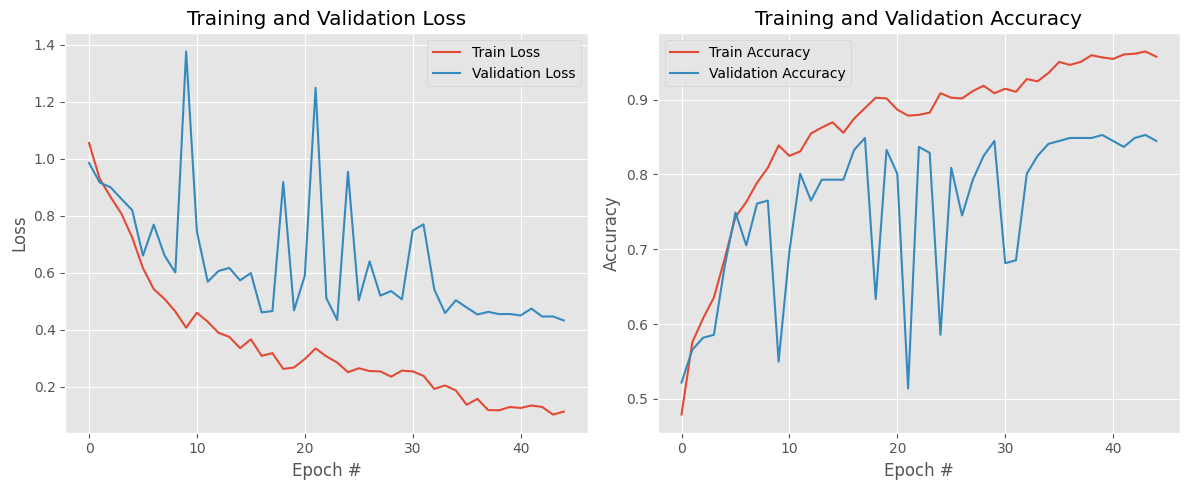

[I 2025-06-15 10:00:57,873] Trial 78 finished with value: 0.852589641434263 and parameters: {'learning_rate': 0.0005280496524799249, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.21038857269597566, 'epochs': 45}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


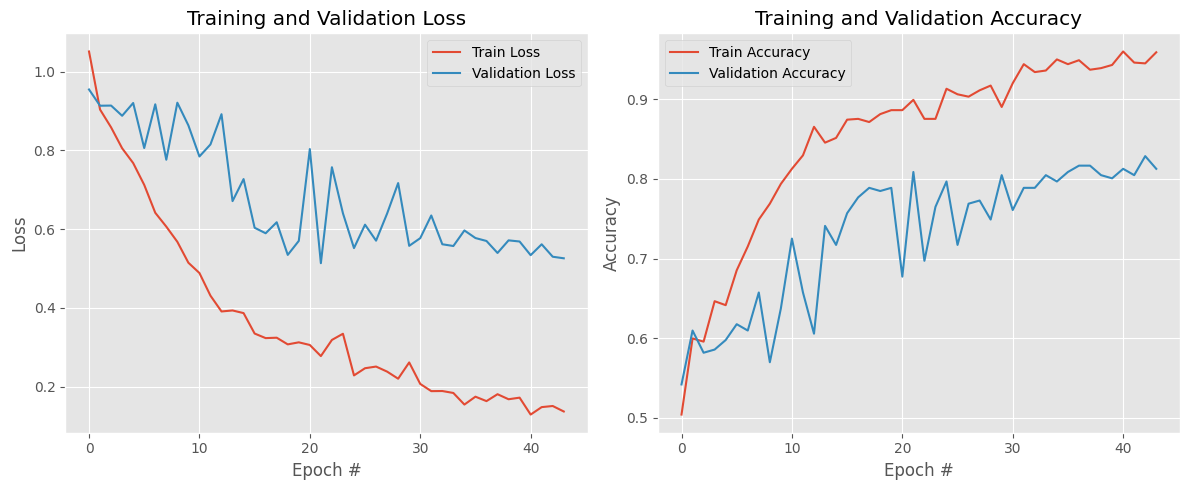

[I 2025-06-15 10:03:22,228] Trial 79 finished with value: 0.8286852589641435 and parameters: {'learning_rate': 0.0001651788786874055, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.20110466389267617, 'epochs': 44}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
[I 2025-06-15 10:03:55,951] Trial 80 pruned. 
C:\Users\migue\AppD

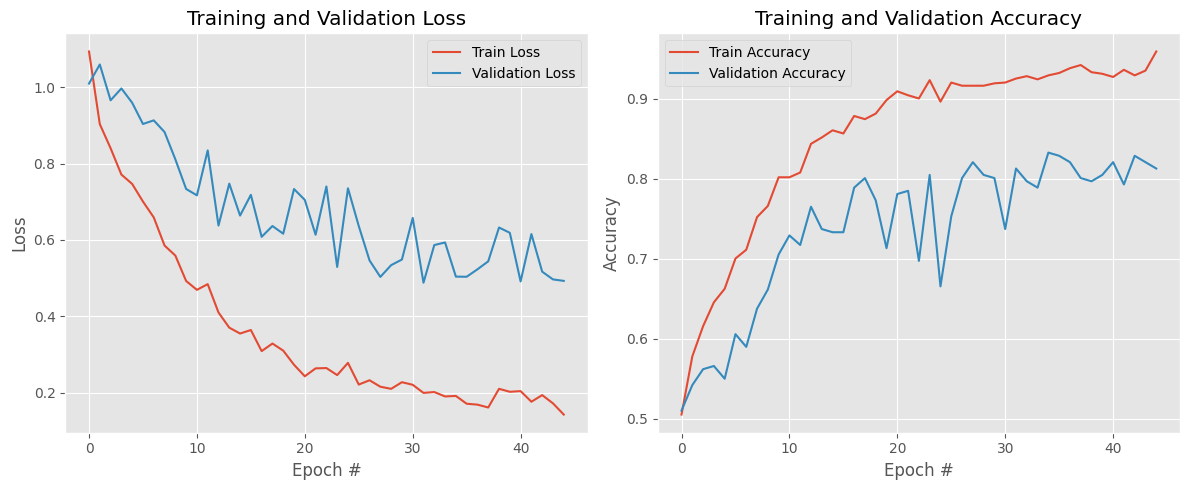

[I 2025-06-15 10:06:24,189] Trial 81 finished with value: 0.8326693227091634 and parameters: {'learning_rate': 0.00031205494439401913, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.2398458037411575, 'epochs': 45}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
[I 2025-06-15 10:06:57,190] Trial 82 pruned. 
C:\Users\migue\AppD

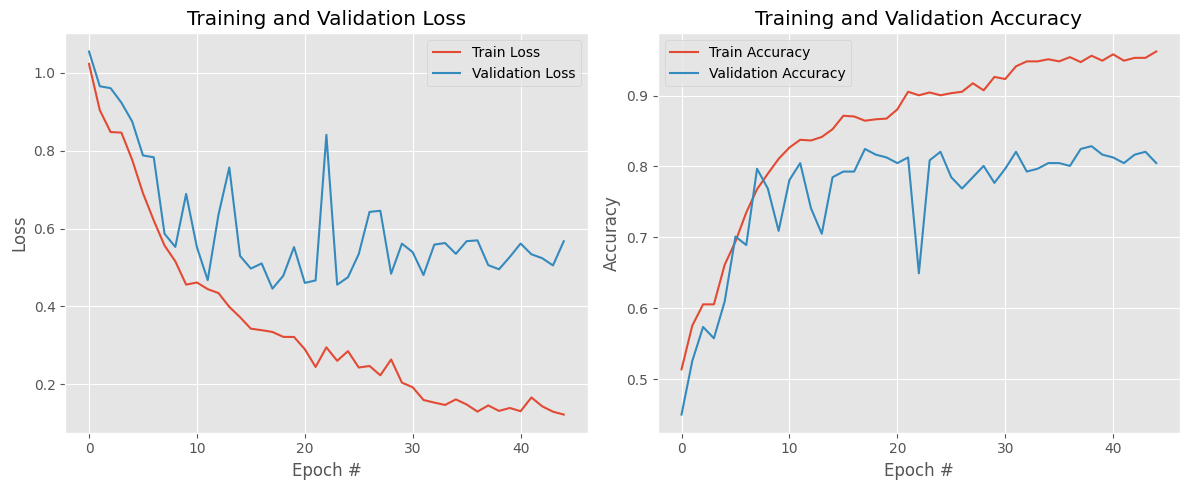

[I 2025-06-15 10:10:09,563] Trial 84 finished with value: 0.8286852589641435 and parameters: {'learning_rate': 0.0006793316802848887, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.2416542486812632, 'epochs': 45}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


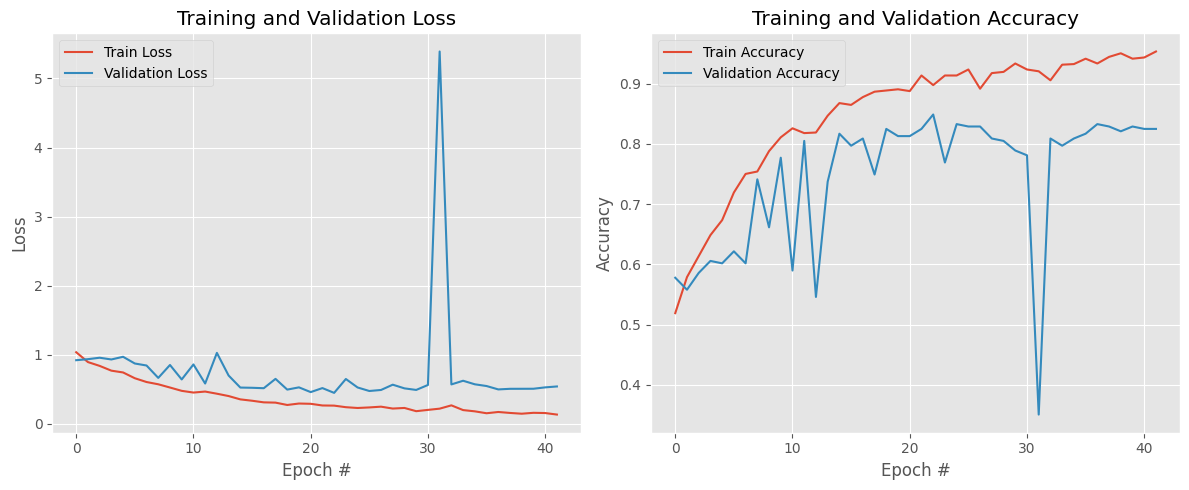

[I 2025-06-15 10:12:38,887] Trial 85 finished with value: 0.848605577689243 and parameters: {'learning_rate': 0.0003144583361238256, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.22920898179094454, 'epochs': 42}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


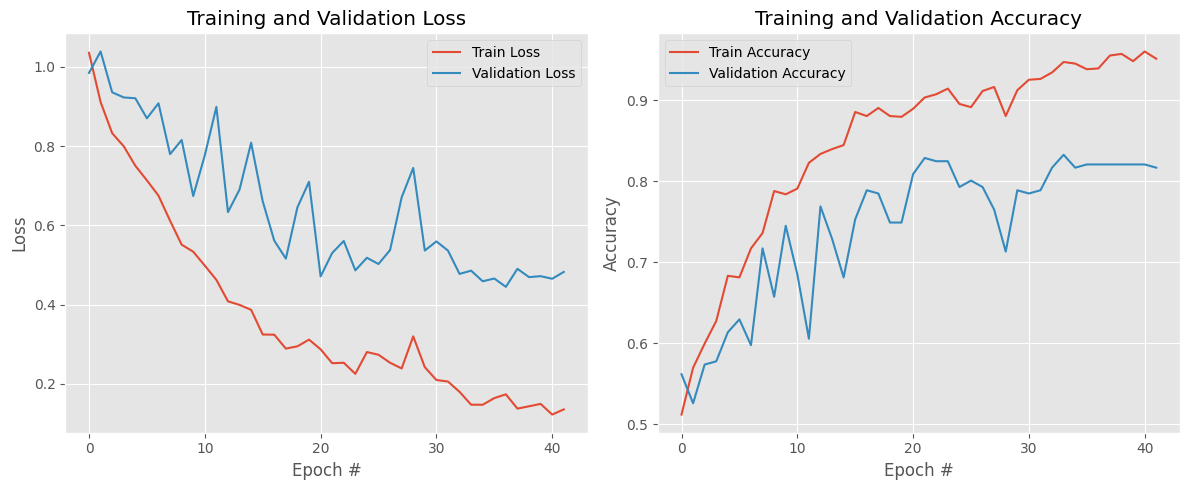

[I 2025-06-15 10:15:08,603] Trial 86 finished with value: 0.8326693227091634 and parameters: {'learning_rate': 0.0003092599054479046, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.2286599709607037, 'epochs': 42}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
[I 2025-06-15 10:15:47,747] Trial 87 pruned. 
C:\Users\migue\AppDa

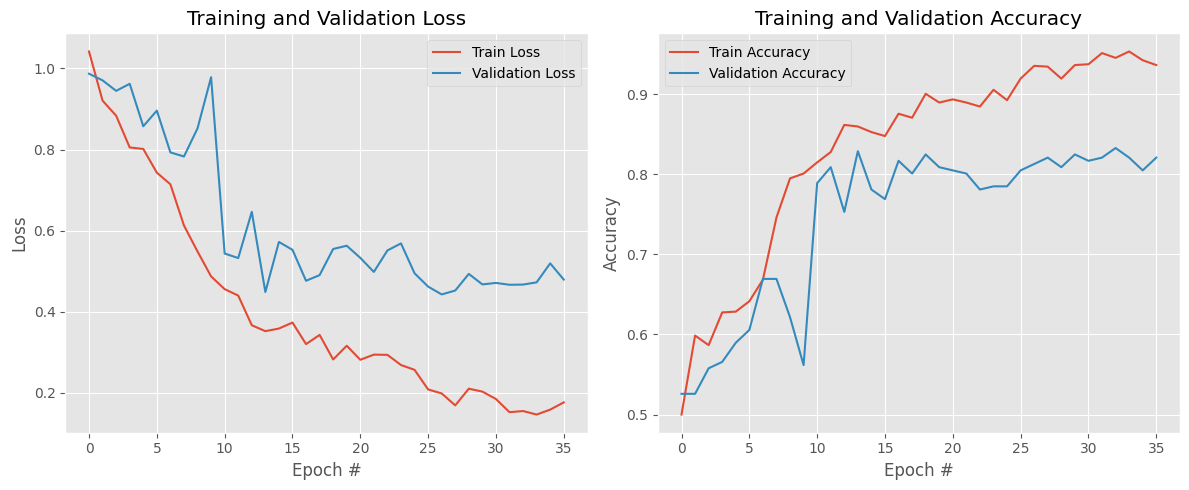

[I 2025-06-15 10:18:35,111] Trial 89 finished with value: 0.8326693227091634 and parameters: {'learning_rate': 0.0004522345413457787, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.2001231153605171, 'epochs': 36}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


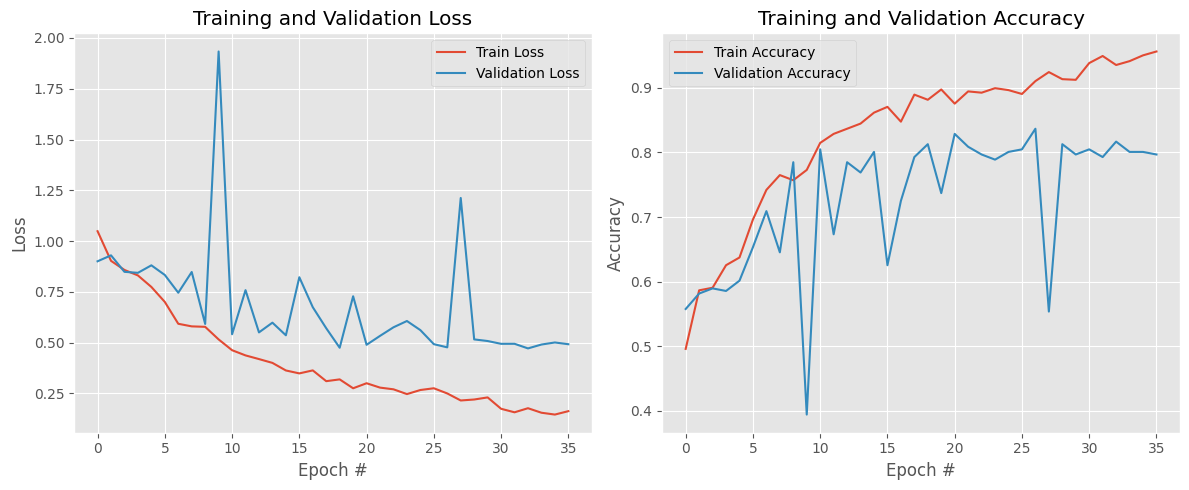

[I 2025-06-15 10:20:43,651] Trial 90 finished with value: 0.8366533864541833 and parameters: {'learning_rate': 0.0004203550594832789, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.2008068699195589, 'epochs': 36}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


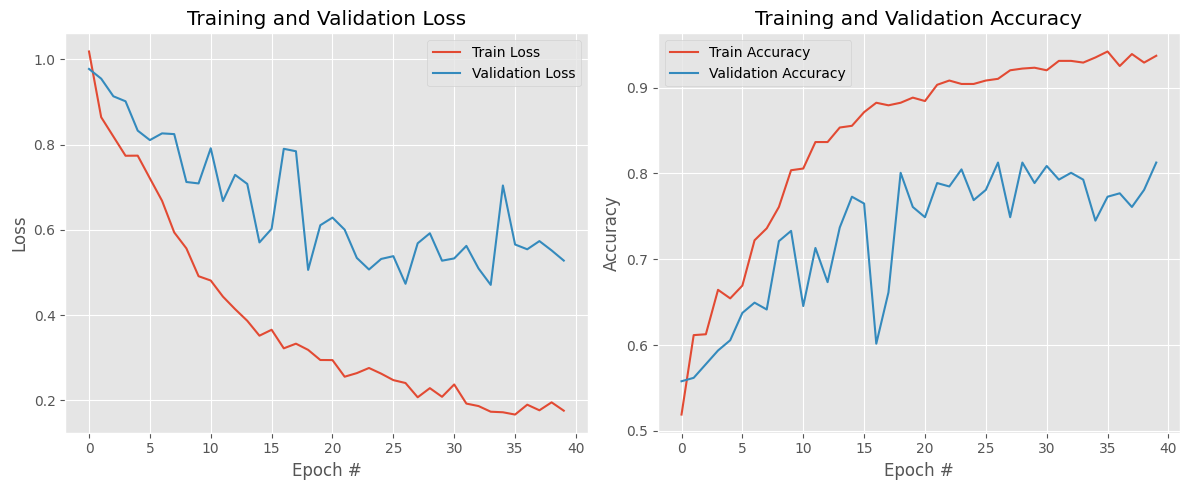

[I 2025-06-15 10:23:05,914] Trial 91 finished with value: 0.8127490039840638 and parameters: {'learning_rate': 0.0003097852035018442, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.21731946096187107, 'epochs': 40}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
[I 2025-06-15 10:23:41,322] Trial 92 pruned. 
C:\Users\migue\AppD

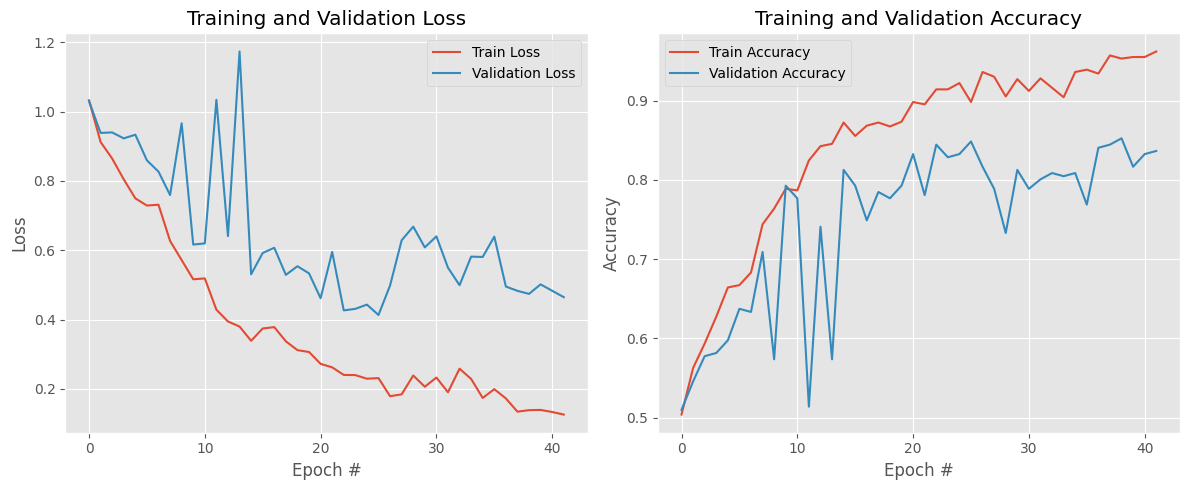

[I 2025-06-15 10:28:14,787] Trial 94 finished with value: 0.852589641434263 and parameters: {'learning_rate': 0.00044348488996065184, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.22967970866175255, 'epochs': 42}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
[I 2025-06-15 10:31:24,253] Trial 95 pruned. 
C:\Users\migue\AppD

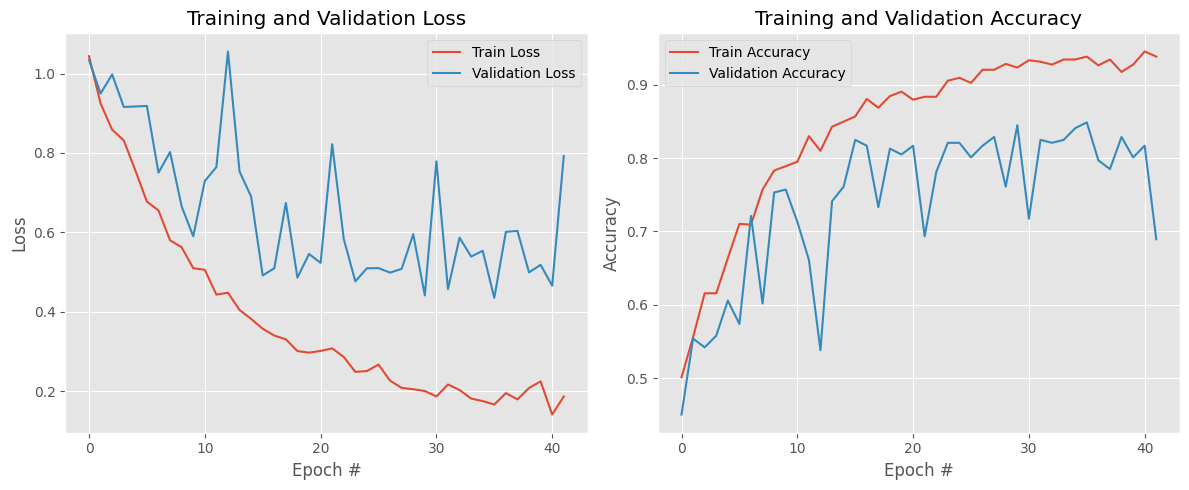

[I 2025-06-15 10:33:46,920] Trial 96 finished with value: 0.848605577689243 and parameters: {'learning_rate': 0.00043771232212497165, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.20817133464401022, 'epochs': 42}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


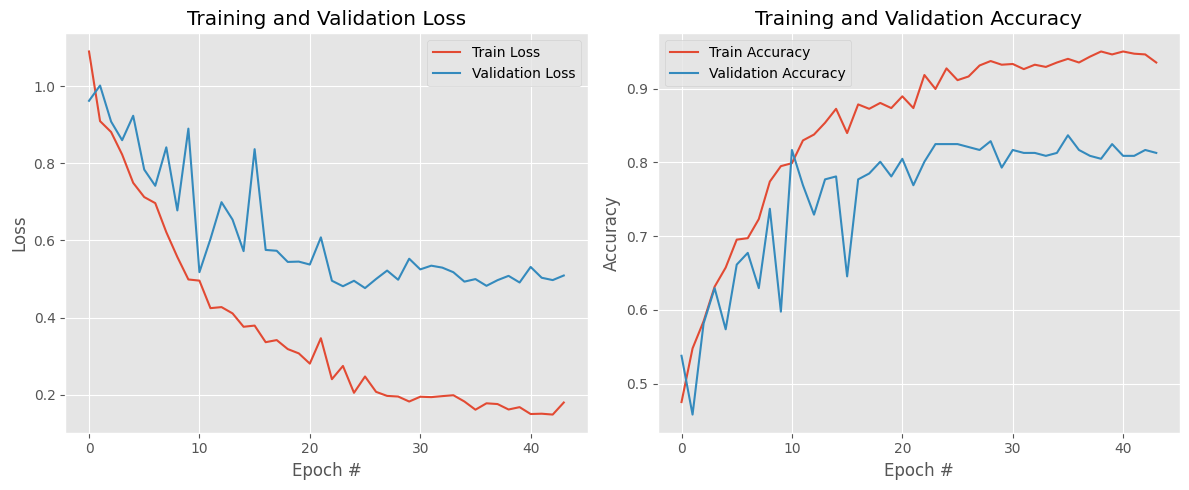

[I 2025-06-15 10:36:13,228] Trial 97 finished with value: 0.8366533864541833 and parameters: {'learning_rate': 0.00044295654262818977, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.20911102427374623, 'epochs': 44}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
[I 2025-06-15 10:38:37,016] Trial 98 pruned. 
C:\Users\migue\App

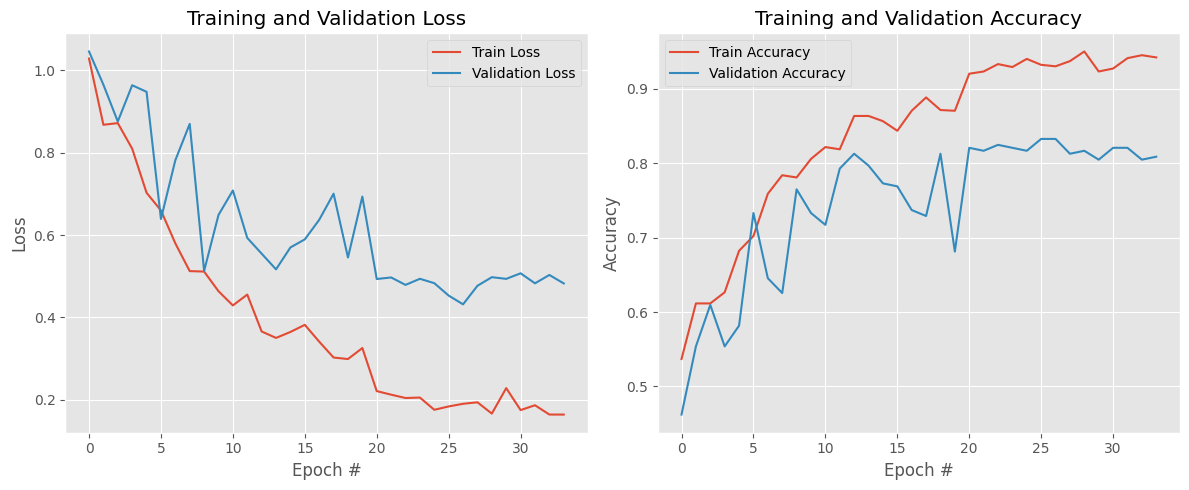

[I 2025-06-15 10:41:02,864] Trial 100 finished with value: 0.8326693227091634 and parameters: {'learning_rate': 0.0006740374593066916, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.2164373202715083, 'epochs': 34}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


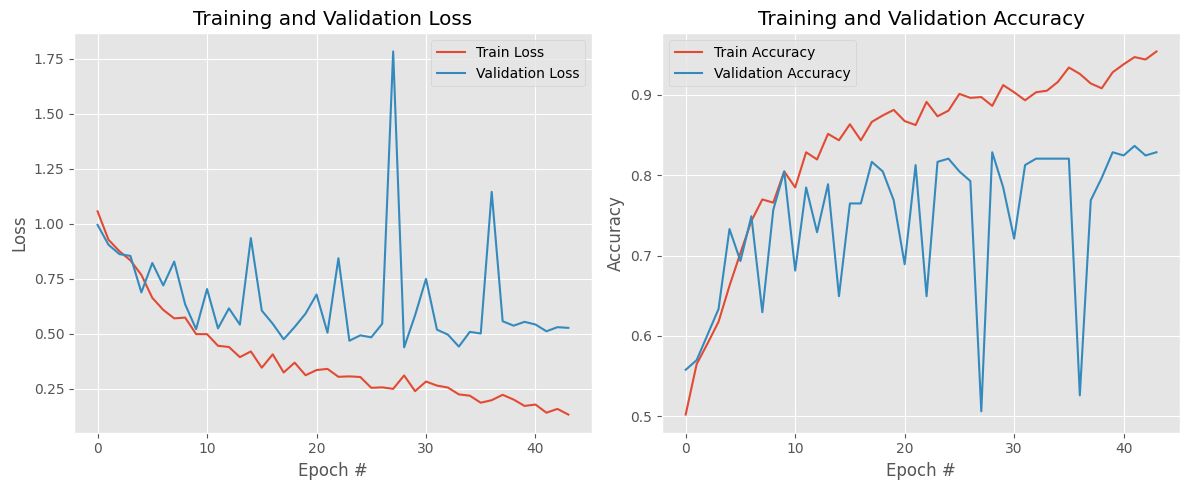

[I 2025-06-15 10:43:29,363] Trial 101 finished with value: 0.8366533864541833 and parameters: {'learning_rate': 0.000888527056608111, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.20925575113890793, 'epochs': 44}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


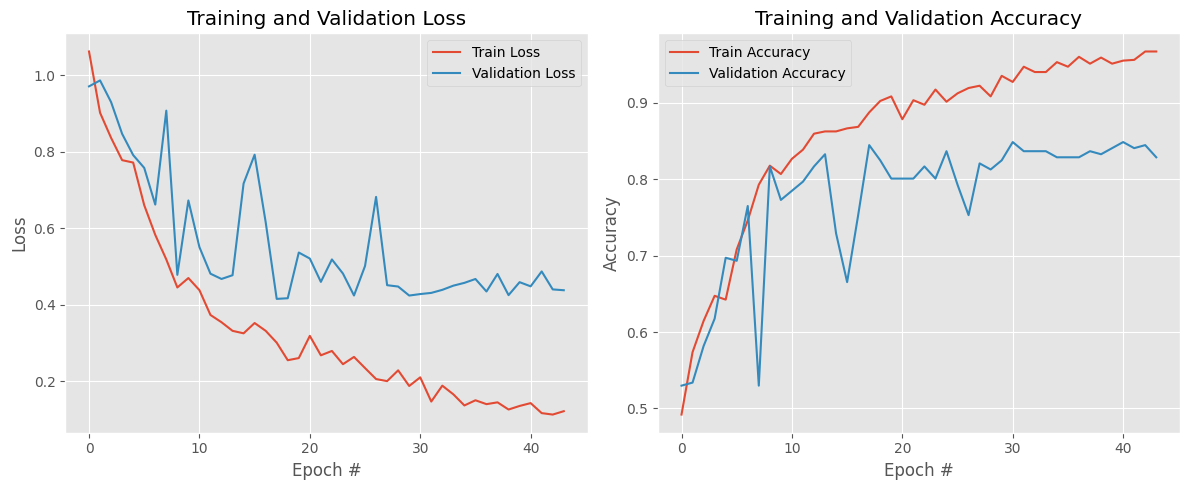

[I 2025-06-15 10:45:56,936] Trial 102 finished with value: 0.848605577689243 and parameters: {'learning_rate': 0.00039588236283478925, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.20680315613557318, 'epochs': 44}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


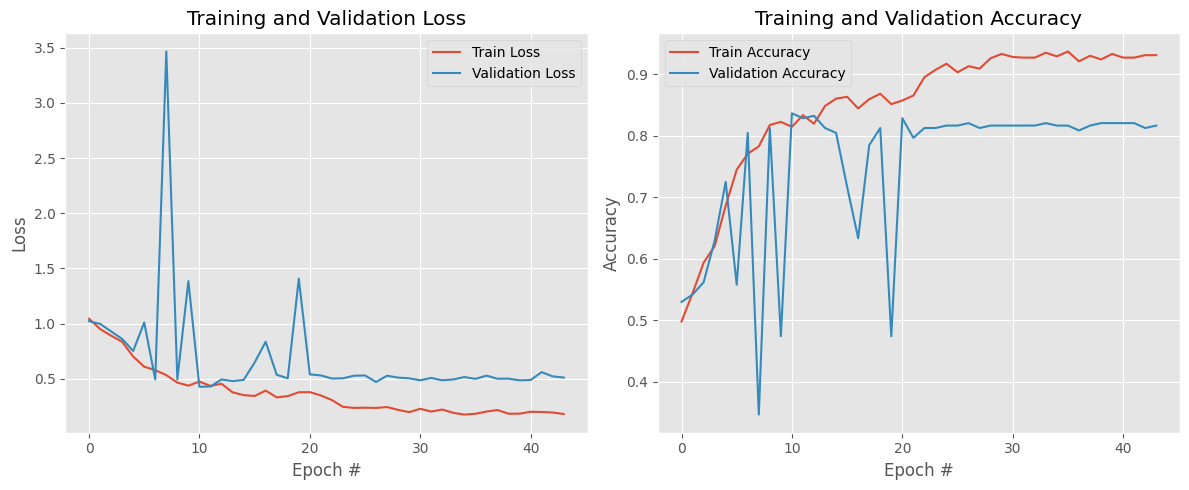

[I 2025-06-15 10:48:29,143] Trial 103 finished with value: 0.8366533864541833 and parameters: {'learning_rate': 0.0008773985910863253, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.20685575704968653, 'epochs': 44}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


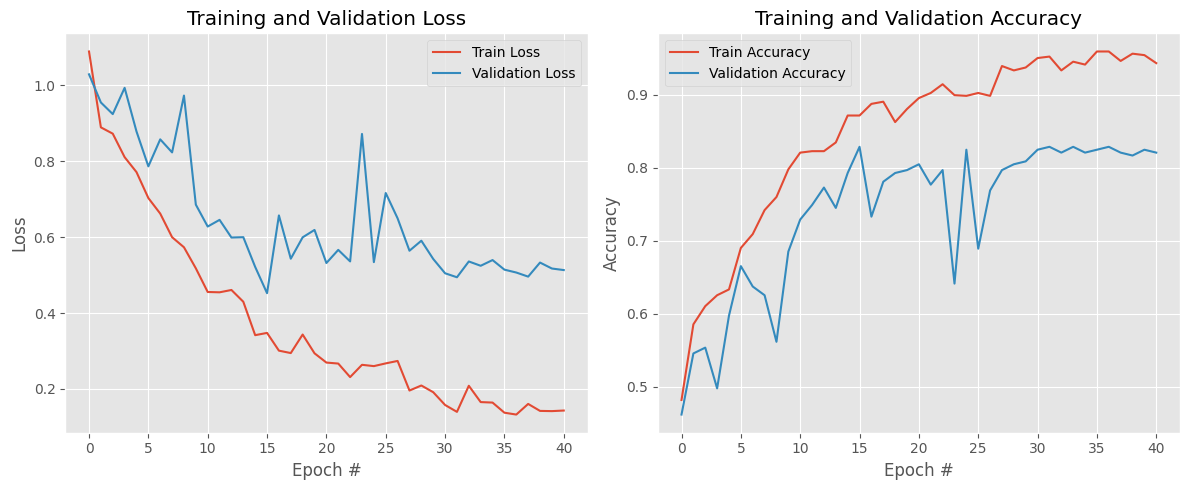

[I 2025-06-15 10:50:54,505] Trial 104 finished with value: 0.8286852589641435 and parameters: {'learning_rate': 0.0004238081381877668, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.2231438841400678, 'epochs': 41}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


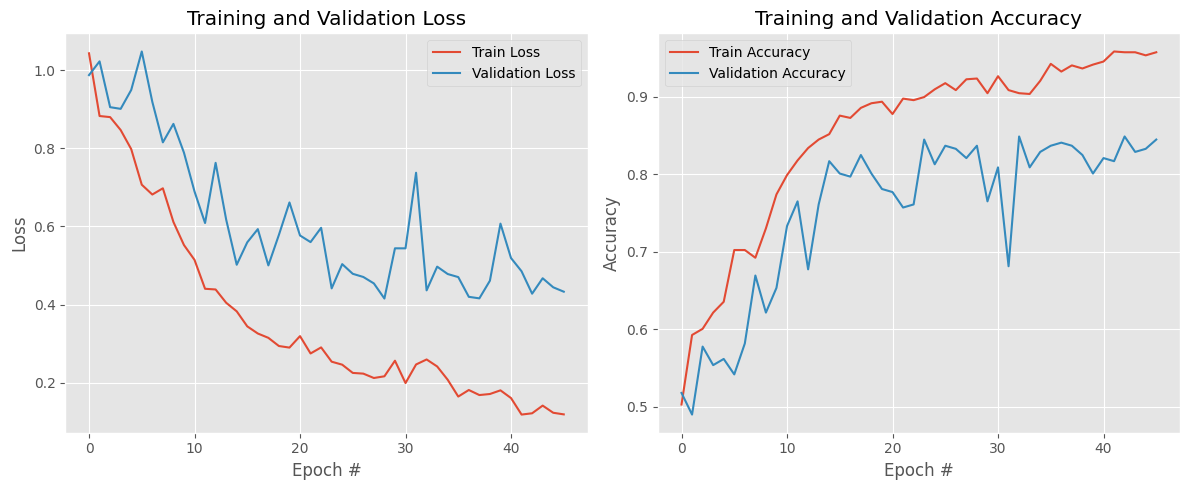

[I 2025-06-15 10:53:37,149] Trial 105 finished with value: 0.848605577689243 and parameters: {'learning_rate': 0.00038818773850875075, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.2109227783460921, 'epochs': 46}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


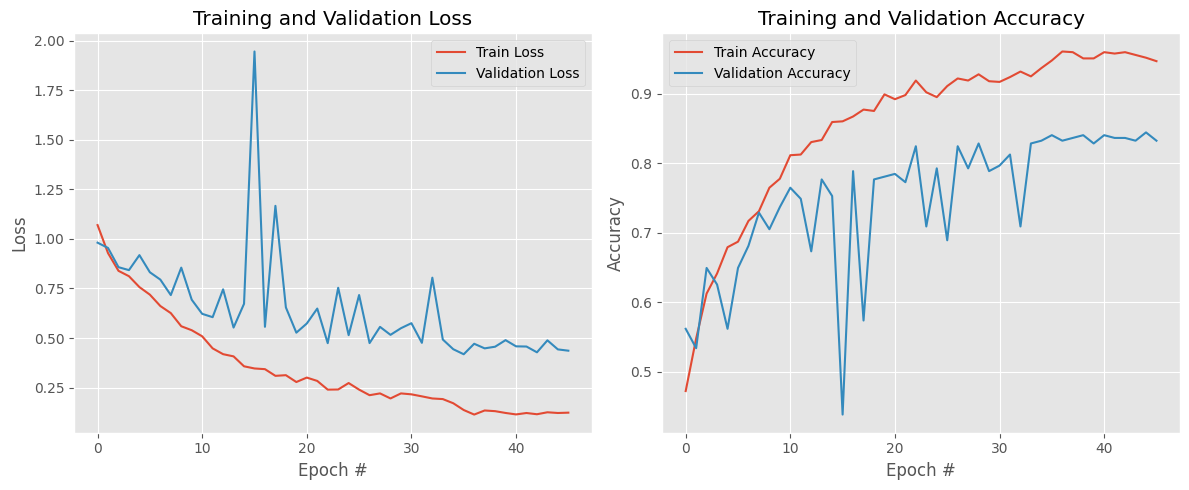

[I 2025-06-15 10:56:20,174] Trial 106 finished with value: 0.8446215139442231 and parameters: {'learning_rate': 0.00038530491140034175, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.21623939367849995, 'epochs': 46}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


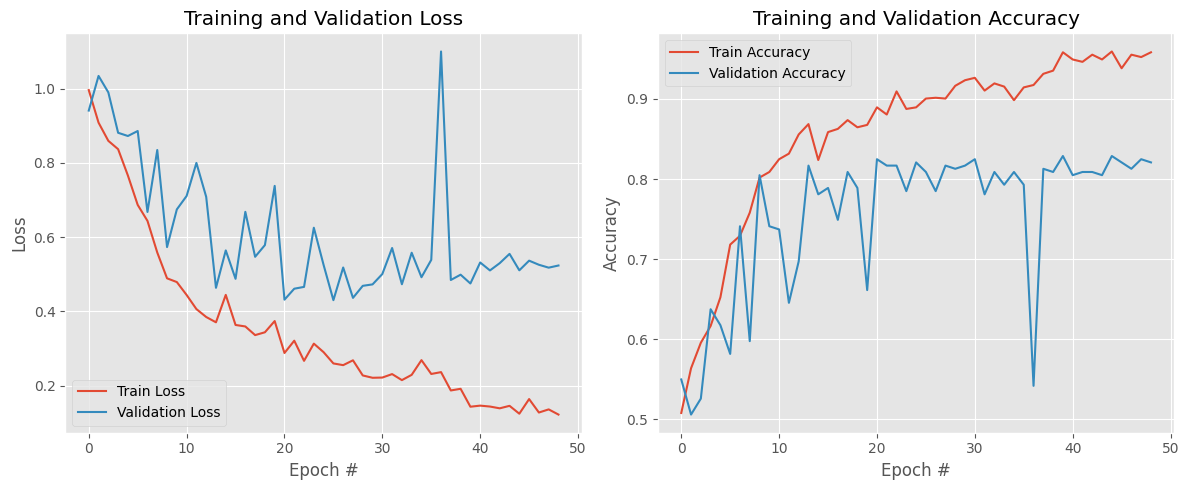

[I 2025-06-15 10:59:00,324] Trial 107 finished with value: 0.8286852589641435 and parameters: {'learning_rate': 0.0005925781848900021, 'batch_size': 16, 'hidden_size': 128, 'dropout_rate': 0.2169520406125522, 'epochs': 49}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
[I 2025-06-15 10:59:39,309] Trial 108 pruned. 
C:\Users\migue\App

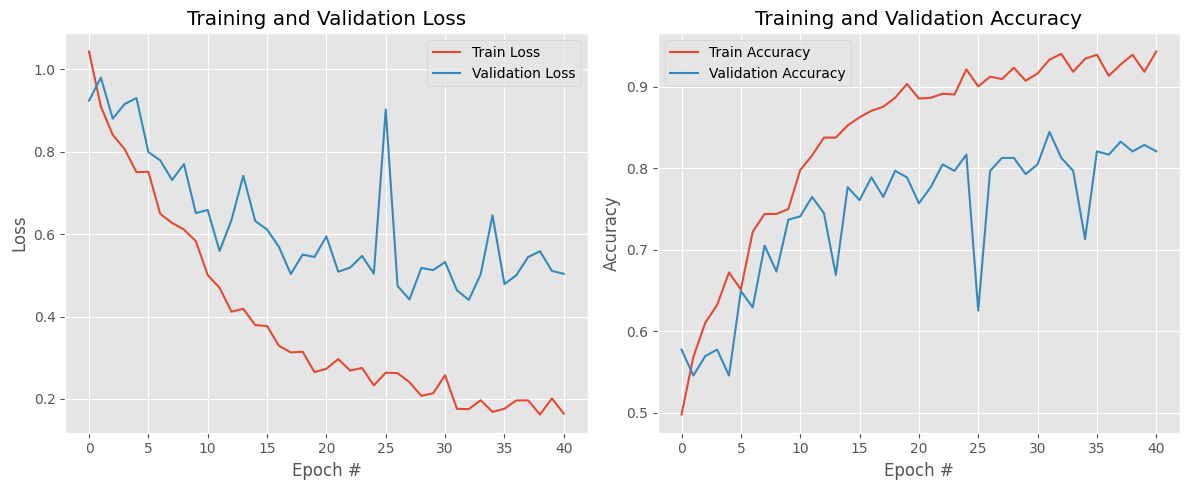

[I 2025-06-15 11:04:37,641] Trial 113 finished with value: 0.8446215139442231 and parameters: {'learning_rate': 0.0004709162030935806, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.20862766183269504, 'epochs': 41}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


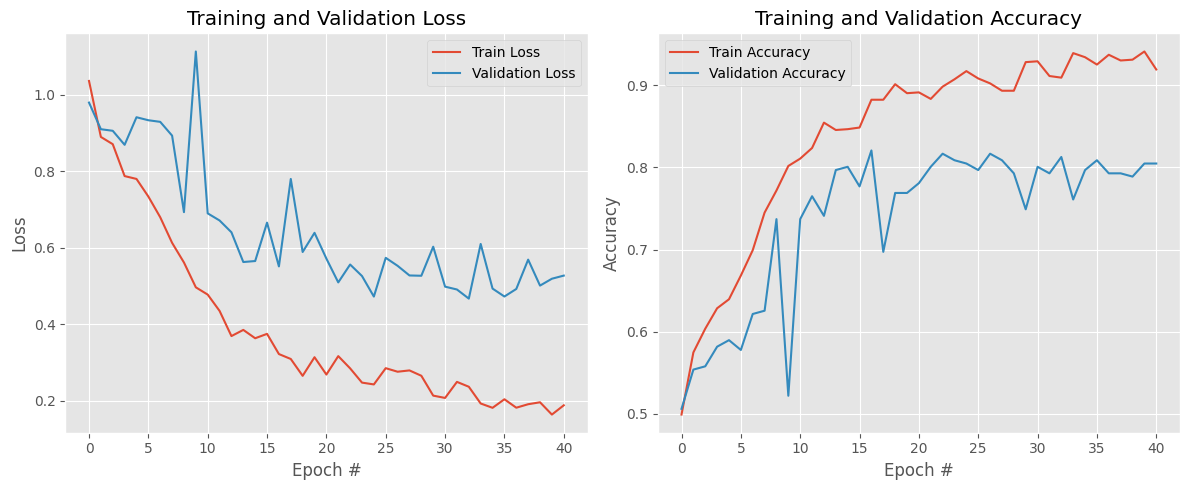

[I 2025-06-15 11:07:02,731] Trial 114 finished with value: 0.8207171314741036 and parameters: {'learning_rate': 0.0003638398762055099, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.22405197551174763, 'epochs': 41}. Best is trial 78 with value: 0.852589641434263.
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\migue\AppData\Local\Temp\ipykernel_11364\3555751409.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


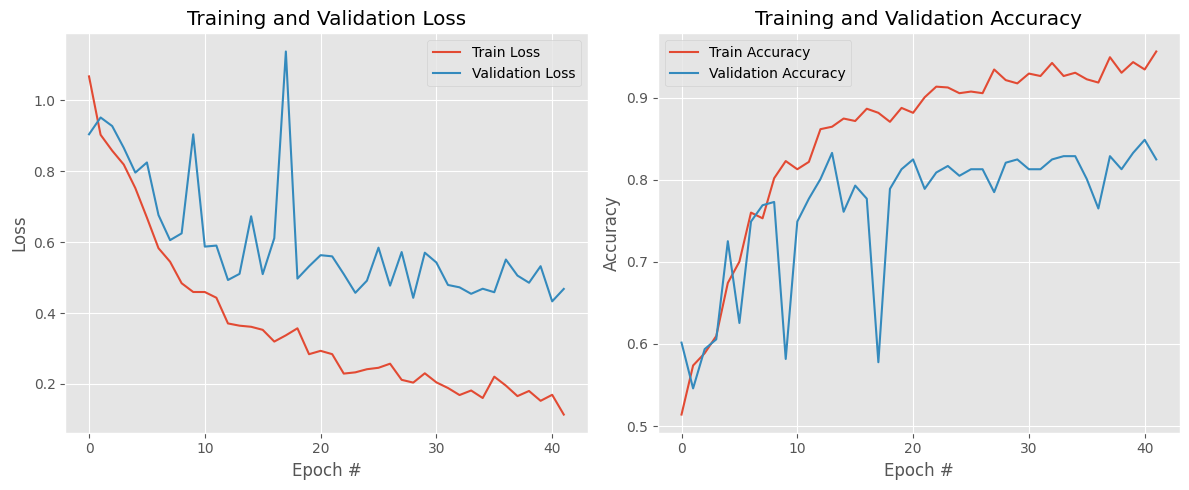

[I 2025-06-15 13:23:18,775] Trial 115 finished with value: 0.848605577689243 and parameters: {'learning_rate': 0.00046588548503250567, 'batch_size': 16, 'hidden_size': 512, 'dropout_rate': 0.2048689409937406, 'epochs': 42}. Best is trial 78 with value: 0.852589641434263.



--- Resultados de la optimización ---
Mejor trial: 0.8526 (Precisión de validación)
Mejores hiperparámetros:
  learning_rate: 0.0005280496524799249
  batch_size: 16
  hidden_size: 512
  dropout_rate: 0.21038857269597566
  epochs: 45


In [44]:
study = optuna.create_study(direction='maximize', 
                            study_name='poi_model_optimization', 
                            storage='sqlite:///db.sqlite3', 
                            load_if_exists=True,
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10))
study.optimize(objective, n_trials=50, timeout=7200) 

print("\n--- Resultados de la optimización ---")
print(f"Mejor trial: {study.best_trial.value:.4f} (Precisión de validación)")
print("Mejores hiperparámetros:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

In [ ]:
best_params = study.best_trial.params

final_model = Model(num_metadata_features=train_features.shape[1], 
                    hidden_size=best_params['hidden_size'], 
                    dropout_rate=best_params['dropout_rate']).to(DEVICE)

print(f"Parámetros del modelo final: LR={best_params['learning_rate']:.5f}, BS={best_params['batch_size']}, HS={best_params['hidden_size']}, DO={best_params['dropout_rate']:.2f}, Epochs={best_params['epochs']}")

final_val_accuracy = train_model(final_model, 
                                 best_params['learning_rate'], 
                                 best_params['epochs'], 
                                 best_params['batch_size'],
                                 trial=None)

print(f"Precisión de validación del modelo final: {final_val_accuracy:.4f}")


test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False, worker_init_fn=seed_worker, generator=g)

final_model.eval()
total_test_preds, total_test_labels = [], []
with torch.no_grad():
    for labels, metadata, images in test_loader:
        labels = labels.to(DEVICE).long()
        metadata = metadata.to(DEVICE).float()
        images = images.to(DEVICE).float()

        outputs = final_model(metadata, images)
        preds = outputs.argmax(dim=1)
        total_test_preds.extend(preds.cpu().numpy())
        total_test_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(total_test_labels, total_test_preds)
print(f"Precisión en el conjunto de test del modelo final: {test_accuracy:.4f}")

Parámetros del modelo final: LR=0.00053, BS=16, HS=512, DO=0.21, Epochs=45
